In [278]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

### Load the data and prepare for the analysis

In [279]:
df = pd.read_csv("features_reads_relative_abundance.tsv", sep="\t")
df_transposed = df.set_index(df.columns[0]).T
df_transposed.columns.name = None  # Remove the name of the columns index
df_transposed.reset_index(inplace=True)
df_transposed.rename(columns={'index': 'sample'}, inplace=True)
df_transposed

,sample,ivig_1,ivig_2,ivig_3,ivig_6,ivig_7,ivig_8,ivig_9,ivig_10,ivig_12,...,uvig_598886,uvig_598887,uvig_598889,uvig_598890,uvig_598893,uvig_598938,uvig_598939,uvig_598940,uvig_598943,uvig_598946
0,C102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
1,C103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
2,C104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.812242e-07,0.0,0.0,0.0
3,C105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
4,C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,P88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
132,P9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
133,P94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
134,P95II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0


In [280]:
# Create a new column mentioned the group (condition) of each sample
# If sample column startswith "C" then the new condition column will be 0 (Control, let's keep it binary)
# If samples column startswith "P" then the new condition column will be 1 (Parkinson, let's keep it binary)
df_transposed['condition'] = df_transposed['sample'].apply(lambda x: 0 if x.startswith('C') else 1)

In [281]:
df_transposed

,sample,ivig_1,ivig_2,ivig_3,ivig_6,ivig_7,ivig_8,ivig_9,ivig_10,ivig_12,...,uvig_598887,uvig_598889,uvig_598890,uvig_598893,uvig_598938,uvig_598939,uvig_598940,uvig_598943,uvig_598946,condition
0,C102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0
1,C103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0
2,C104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.812242e-07,0.0,0.0,0.0,0
3,C105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0
4,C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,P88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1
132,P9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1
133,P94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1
134,P95II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1


### Split the data into features and labels (X (feature matrix) and y (label vector))

In [282]:
var_names = df_transposed.columns.tolist()[1:-1]
X = df_transposed.iloc[:,1:-1]
y = df_transposed.iloc[:,-1]

# the data is already normalized (we work), so we can skip normalization
# the label vector is also binary (0: Control, 1:Parkinson), so we can skip encoding
X = np.array(X)
y = np.array(y)

### Random Forest Classification with 10-fold cross-validation

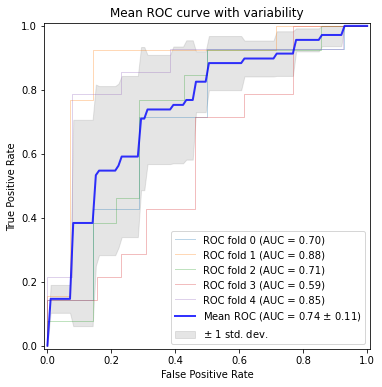

In [283]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
classifier = RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=10, random_state=6969)

tprs = []
aucs = []
f1s = []
recalls = []
precisions = []
accuracies = []
feature_importances = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = sklearn.metrics.RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    preds = classifier.predict(X[test])
    f1_scoring = f1_score(y[test], preds)
    recall_scoring = recall_score(y[test], preds)
    precision_scoring = precision_score(y[test], preds)
    accuracy_scoring = accuracy_score(y[test], preds)
    f1s.append(f1_scoring)
    recalls.append(recall_scoring)
    precisions.append(precision_scoring)
    accuracies.append(accuracy_scoring)
    fold_importances = classifier.feature_importances_
    feature_importances.append(fold_importances)


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability"
)
ax.legend(loc="lower right")
plt.show()

### Check which feature was the most usefull for the data using feature_importances

In [284]:
feature_importances_df = pd.DataFrame(feature_importances, columns=var_names)
feature_importances_mean = feature_importances_df.mean()
feature_importances_std = feature_importances_df.std()


In [285]:
#get the top 50 features
top50 = feature_importances_mean.sort_values(ascending=False).head(50)
print(top50.head(5))
#get only the names
top50_names = top50.index.tolist()

uvig_130451    0.002362
uvig_463921    0.002079
uvig_187852    0.001841
uvig_312390    0.001840
uvig_114087    0.001796
dtype: float64


### Re-run the model with only top50 phages. (top feature importances)

In [286]:
#modify the df_transposed dataframe, so that we have only the columns of top50_names
df_transposed_top50 = df_transposed[['sample'] + top50_names + ['condition']]

In [287]:
df_transposed_top50

,sample,uvig_130451,uvig_463921,uvig_187852,uvig_312390,uvig_114087,uvig_137940,uvig_145736,uvig_132349,uvig_12046,...,uvig_134234,uvig_361772,uvig_397663,uvig_413387,uvig_320542,uvig_219647,uvig_69625,uvig_438986,uvig_137525,condition
0,C102,0.000007,5.515571e-05,0.000405,1.145542e-07,4.004516e-07,0.000021,0.000001,0.000033,6.089803e-07,...,7.244294e-07,2.078320e-04,9.301981e-06,0.000000,0.000045,0.000018,3.378142e-05,0.000002,5.268122e-05,0
1,C103,0.000059,2.110598e-05,0.000010,4.173960e-06,3.789891e-07,0.000007,0.000051,0.000002,6.051587e-05,...,3.283678e-06,1.096942e-05,1.311150e-06,0.000000,0.000005,0.000215,0.000000e+00,0.000190,8.617387e-06,0
2,C104,0.000151,6.040218e-07,0.000010,9.266622e-07,2.313836e-07,0.000027,0.000131,0.000009,8.436154e-05,...,3.778237e-06,5.715666e-06,7.004325e-06,0.000009,0.000014,0.000434,3.539739e-07,0.000121,5.918804e-05,0
3,C105,0.000042,4.292100e-06,0.000007,6.285435e-06,0.000000e+00,0.000010,0.000072,0.000008,4.057408e-05,...,7.471520e-07,3.356593e-07,6.980983e-06,0.000000,0.000012,0.000247,8.231866e-06,0.000270,3.122507e-05,0
4,C1,0.000045,2.512537e-05,0.000079,5.870298e-06,2.963099e-06,0.000002,0.000042,0.000004,3.288484e-05,...,6.260731e-06,7.991182e-05,9.814913e-07,0.000002,0.000079,0.000157,9.644660e-07,0.000281,5.733993e-06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,P88,0.000174,7.617661e-07,0.000032,1.636133e-05,1.139522e-04,0.000009,0.000192,0.000077,1.879353e-04,...,3.889754e-07,2.217114e-05,2.019097e-06,0.000000,0.000067,0.000575,9.374747e-06,0.000749,2.032014e-05,1
132,P9,0.000579,1.845396e-05,0.000010,1.107830e-05,3.073561e-07,0.000000,0.000478,0.000031,5.635757e-04,...,8.603626e-06,8.002639e-05,0.000000e+00,0.000000,0.000026,0.001780,0.000000e+00,0.000697,4.367879e-07,1
133,P94,0.000032,2.473077e-05,0.000042,3.942645e-06,3.424214e-07,0.000011,0.000031,0.000047,2.460458e-05,...,1.141094e-06,1.761340e-04,2.369281e-06,0.000002,0.000003,0.000073,0.000000e+00,0.000524,3.552325e-05,1
134,P95II,0.000752,4.176108e-05,0.000031,0.000000e+00,3.332810e-07,0.000000,0.000676,0.000025,7.885034e-04,...,1.110634e-07,1.043646e-04,0.000000e+00,0.000000,0.000039,0.002328,0.000000e+00,0.000002,0.000000e+00,1


In [288]:
var_names = df_transposed.columns.tolist()[1:-1]
X_top50 = df_transposed_top50.iloc[:,1:-1]
y_top50 = df_transposed_top50.iloc[:,-1]

# the data is already normalized (we work), so we can skip normalization
# the label vector is also binary (0: Control, 1:Parkinson), so we can skip encoding
X_top50 = np.array(X_top50)
y_top50 = np.array(y_top50)

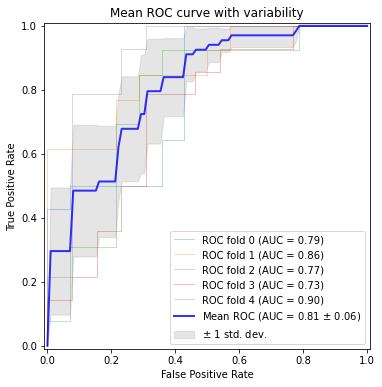

In [289]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
classifier = RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=10, random_state=6969)

tprs = []
aucs = []
f1s = []
recalls = []
precisions = []
accuracies = []
feature_importances = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_top50, y_top50)):
    classifier.fit(X_top50[train], y_top50[train])
    viz = sklearn.metrics.RocCurveDisplay.from_estimator(
        classifier,
        X_top50[test],
        y_top50[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    preds = classifier.predict(X_top50[test])
    f1_scoring = f1_score(y_top50[test], preds)
    recall_scoring = recall_score(y_top50[test], preds)
    precision_scoring = precision_score(y_top50[test], preds)
    accuracy_scoring = accuracy_score(y_top50[test], preds)
    f1s.append(f1_scoring)
    recalls.append(recall_scoring)
    precisions.append(precision_scoring)
    accuracies.append(accuracy_scoring)
    fold_importances = classifier.feature_importances_
    feature_importances.append(fold_importances)


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability"
)
ax.legend(loc="lower right")
plt.show()

### Load the publicly available data for testing

Twenty random samples (10 Parkinson's disease, 10 control) were selected from publicly available shotgun metagenomics data within the ENA project PRJNA834801. The sequences were mapped to GDP data, which was subsequently employed as a test dataset to evaluate our model's performance on unseen data.

In [290]:
test_set_data = pd.read_csv("validation_public_data/features_reads_relative_abundance.tsv", sep="\t")
test_set_data
metadata_for_test = pd.read_csv("validation_public_data/metadata.csv", sep="\t")

In [291]:
test_set_data_t = test_set_data.set_index(df.columns[0]).T
test_set_data_t.columns.name = None  # Remove the name of the columns index
test_set_data_t.reset_index(inplace=True)
test_set_data_t.rename(columns={'index': 'sample'}, inplace=True)

In [292]:
test_set_data_t["Condition"] = metadata_for_test["Condition"]

### Split the test data into features and labels (X (feature matrix) and y (label vector))

In [294]:
X_test = test_set_data_t.iloc[:,1:-1]
y_test = test_set_data_t.iloc[:,-1]

# the data is already normalized (we work), so we can skip normalization
# the label vector is also binary (0: Control, 1:Parkinson), so we can skip encoding
X_test = np.array(X_test)
y_test = np.array(y_test)

### Run the Random forest model using all our data (136 samples)

In [295]:
classifier = RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=10, random_state=6969)
classifier.fit(X,y)
preds = classifier.predict(X_test)
preds

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1])

### Get the recall, precision, accuracy, and f1-score

In [297]:
recall_scoring = recall_score(y_test, preds)
precision_scoring = precision_score(y_test, preds)
accuracy_scoring = accuracy_score(y_test, preds)
f1_scoring = f1_score(y_test, preds)
print(f"Recall: {recall_scoring}")
print(f"Precision: {precision_scoring}")
print(f"Accuracy: {accuracy_scoring}")
print(f"F1: {f1_scoring}")

Recall: 0.8
Precision: 0.8
Accuracy: 0.8
F1: 0.8


### Test also the top50 features with the test data

In [298]:
#modify the test_set_data_t dataframe, so that we have only the columns of top50_names
test_set_data_t_top50 = test_set_data_t[['sample'] + top50_names + ['Condition']]

In [299]:
X_test_top50 = test_set_data_t_top50.iloc[:,1:-1]
y_test_top50 = test_set_data_t_top50.iloc[:,-1]

# the data is already normalized (we work), so we can skip normalization
# the label vector is also binary (0: Control, 1:Parkinson), so we can skip encoding
X_test_top50 = np.array(X_test_top50)
y_test_top50 = np.array(y_test_top50)

In [300]:
classifier = RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=10, random_state=6969)
classifier.fit(X_top50,y_top50)
preds = classifier.predict(X_test_top50)
preds

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1])

In [301]:
recall_scoring = recall_score(y_test, preds)
precision_scoring = precision_score(y_test, preds)
accuracy_scoring = accuracy_score(y_test, preds)
f1_scoring = f1_score(y_test, preds)
print(f"Recall: {recall_scoring}")
print(f"Precision: {precision_scoring}")
print(f"Accuracy: {accuracy_scoring}")
print(f"F1: {f1_scoring}")

Recall: 0.5
Precision: 0.5555555555555556
Accuracy: 0.55
F1: 0.5263157894736842
